In [54]:
# converting dataset to vector using chroma and save it locally.
import pandas as pd
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma 

from dotenv import load_dotenv
import glob
import os
load_dotenv()

csv_files = [
    "nutrition_knowledge_base.csv",
    "diet_recommendations_dataset.csv"
]

# -------------------------------
# 2. Load all CSV files
# -------------------------------
combined_text = ""

for csv_path in csv_files:
    if not os.path.exists(csv_path):
        print(f"❌ File not found: {csv_path}")
        continue

    df = pd.read_csv(csv_path)

    combined_text += f"\n\n==== FILE: {csv_path} ====\n\n"

    for _, row in df.iterrows():
        row_text = "\n".join([f"{col}: {row[col]}" for col in df.columns])
        combined_text += row_text + "\n\n"

# Create ONE SINGLE DOCUMENT
single_document = [
    Document(
        page_content=combined_text,
        metadata={"source": "merged_csv_files"}
    )
]
print("📌 Combined single document created")


# --- 1c. Build Vector Store ---
vectorstore = Chroma.from_documents(
    documents=single_document,
    collection_name="merged_csv_collection",
    embedding=OpenAIEmbeddings(),
    persist_directory="./chroma_db"
)
print("✅ Vector DB created & saved to ./chroma_db")

retriever = vectorstore.as_retriever(search_kwargs={"k": 3})




📌 Combined single document created
✅ Vector DB created & saved to ./chroma_db


In [55]:
results=retriever.invoke("my name is xyz i age is 23, height is 168 , i want to loose a wiegth so give me diet plan")

In [56]:
import os
from typing import List, Dict, Any,TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
chat = ChatOpenAI(model="gpt-4o-mini")



In [57]:
from typing import TypedDict, List
from pydantic import BaseModel, Field

# 1. Strict Input Schema (The "User Input" you requested)
class UserProfile(BaseModel):
    name: str
    age: int
    gender: str = Field(..., description="male or female")
    height_cm: float
    weight_kg: float
    activity_level: str = Field("sedentary", description="sedentary, light, moderate, active")
    goal: str = Field("weight_loss", description="weight_loss, maintain, muscle_gain")
    dietary_preference: str = Field(..., description="vegetarian, non_vegetarian, vegan, eggetarian")

# 2. Graph State (Shared memory between agents)
class AgentState(TypedDict):
    profile: UserProfile       # The input data
    metrics: dict              # Calculated BMR, TDEE, BMI
    relevant_docs: List[str]   # Retrieved chunks from your DB
    final_plan: str            # The output diet plan

In [58]:
def calculate_metrics_node(state: AgentState):
    user = state["profile"]
    
    # 1. Calculate BMI
    height_m = user.height_cm / 100
    bmi = user.weight_kg / (height_m ** 2)
    
    # 2. Calculate BMR (Mifflin-St Jeor Equation)
    if user.gender.lower() == "male":
        bmr = (10 * user.weight_kg) + (6.25 * user.height_cm) - (5 * user.age) + 5
    else:
        bmr = (10 * user.weight_kg) + (6.25 * user.height_cm) - (5 * user.age) - 161
        
    # 3. Calculate TDEE (Total Daily Energy Expenditure)
    activity_multipliers = {
        "sedentary": 1.2, "light": 1.375, 
        "moderate": 1.55, "active": 1.725
    }
    tdee = bmr * activity_multipliers.get(user.activity_level, 1.2)
    
    # 4. Determine Target Calories
    if user.goal == "weight_loss":
        target_calories = tdee - 500  # Standard deficit
    elif user.goal == "muscle_gain":
        target_calories = tdee + 300
    else:
        target_calories = tdee

    # Update state
    return {
        "metrics": {
            "bmi": round(bmi, 2),
            "bmr": round(bmr, 0),
            "tdee": round(tdee, 0),
            "target_calories": round(target_calories, 0)
        }
    }

Agents function


In [ ]:
def retrieval_node(state: AgentState):
    user = state["profile"]
    metrics = state["metrics"]
    
    # 1. Construct the Semantic Query
    query = f"High protein {user.dietary_preference} breakfast and lunch options for {metrics['target_calories']} calorie diet"
    
    # 2. Define the Strict Filter (Pseudo-code for generic Vector Store)
    # This prevents Non-Veg items from even being retrieved.
    search_kwargs = {"k": 5}
    
    if user.dietary_preference == "vegetarian":
        # Example filter syntax (varies by DB like Chroma, Pinecone, etc.)
        search_kwargs["filter"] = {"category": {"$ne": "meat"}} 
    elif user.dietary_preference == "vegan":
        search_kwargs["filter"] = {"category": {"$in": ["plant-based", "vegetable", "grain"]}}
        
    # 3. Fetch Data (Mocking the database call)
    docs = retriever.invoke(query, **search_kwargs)
    
    # Simulated Result based on Filter
    if user.dietary_preference == "vegetarian":
        docs = [
            "Food DB: Paneer (100g) = 265 kcal, Protein 18g",
            "Food DB: Lentils/Dal (1 bowl) = 104 kcal, Protein 9g",
           
        ]
    else:
        docs = [
            "Food DB: Chicken Breast (100g) = 165 kcal, Protein 31g",
            "Food DB: Egg Whites (3) = 51 kcal, Protein 11g",
            "Case Study: Lean meat diet plan for muscle gain."
        ]
    
    return {"relevant_docs": docs}

In [66]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI # Or your preferred LLM

llm = ChatOpenAI(model="gpt-4o") # Use a capable model for reasoning

def generation_node(state: AgentState):
    user = state["profile"]
    metrics = state["metrics"]
    docs = "\n".join(state["relevant_docs"])
    
    # Updated System Message
# Updated System Message with FORMATTING RULES
    system_msg = f"""You are an expert Clinical Nutritionist.
    Your are free to add your diet recommendations.
    
    RULES:
    1. STRICTLY adhere to the Target Calories: {metrics['target_calories']} kcal.
    2. The user is **{user.dietary_preference.upper()}**. Do NOT recommend any food that violates this.
    3. Use the provided context to build the plan.
    
    FORMATTING INSTRUCTION:
    - First, give a 2-sentence summary of the strategy.
    - Second, provide the Diet Plan in a **MARKDOWN TABLE** with these columns: 
      | Meal Time | Food Item | Portion Size | Est. Calories | Protein (g) |
    - 
    - Finally, list the Total Daily Calories and Protein at the bottom, 
    """
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_msg),
        ("human", "Create a daily meal plan for {name}. Context: {context}")
    ])
    
    chain = prompt | llm
    
    response = chain.invoke({
        "name": user.name,
        "context": docs
    })
    
    return {"final_plan": response.content}

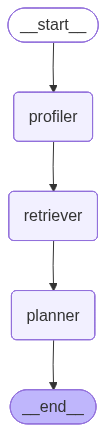

In [67]:
from langgraph.graph import StateGraph, END

# Initialize Graph
workflow = StateGraph(AgentState)

# Add Nodes
workflow.add_node("profiler", calculate_metrics_node)
workflow.add_node("retriever", retrieval_node)
workflow.add_node("planner", generation_node)

# Add Edges (Linear flow for this V1)
workflow.set_entry_point("profiler")
workflow.add_edge("profiler", "retriever")
workflow.add_edge("retriever", "planner")
workflow.add_edge("planner", END)

# Compile
app = workflow.compile()
app

In [68]:
# User Input (This is the object you take from your frontend/Streamlit)
user_data = UserProfile(
    name=input('enter your name'),
    age=input('enter your age'),
    gender=input('enter your gender'),
    height_cm=input('enter your height_cm'),
    weight_kg=input('enter your weight_kg'),
    dietary_preference="vegetarian",
    goal=input('enter your goal')
  
)

# Execution
inputs = {"profile": user_data}
result = app.invoke(inputs)

# Output
print(f"Calculated Target Calories: {result['metrics']['target_calories']}")
print("---------------------------------------------------")
print(result['final_plan'])

Calculated Target Calories: 1899.0
---------------------------------------------------
To achieve the target of 1899 calories while ensuring adequate protein intake for a vegetarian male like Hardik, this meal plan strategically incorporates paneer and lentils for their high protein values, alongside other nutritious vegetarian options. This plan balances macronutrient dense foods with moderate calories to meet dietary needs without relying on whey protein supplements.

| Meal Time   | Food Item            | Portion Size | Est. Calories | Protein (g) |
|-------------|----------------------|--------------|---------------|-------------|
| Breakfast   | Paneer, cooked       | 150g         | 398 kcal      | 27g         |
|             | Whole Grain Toast    | 2 slices     | 180 kcal      | 7g          |
| Mid-Morning | Mixed Fruit Salad    | 1 bowl       | 150 kcal      | 2g          |
| Lunch       | Lentils/Dal          | 2 bowls      | 208 kcal      | 18g         |
|             | Brown